# Cleverly Challenge

This works as my submission of the cleverly challenge.
The challenge consists in the [Amazon products review dataset](http://jmcauley.ucsd.edu/data/amazon/) (Clothing, Shoes and Jewlry)

This dataset consists 278677 reviews about these types of items where each row in the dataset has the followng information:
- reviewrID - ID of the reviewer (39387 unique values)
- asin - ID of the product (23033 unique values)
- reviewerName - name of the reviewer
- helpful - a tuple containing the number of "Yes" votes, and the total number of votes
- reviewText - The main body text of the review
- overall - The rating the user gave the product
- summary - A short summary of the review
- UnixReviewTime - Unix timestamp of the review
- reviewTime - Time of the review (raw)

In [ ]:
# Download nltk stopwords and punkt
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

In [1]:
import ast # for evaluating string representation of lists
import nltk
import string
import itertools # for chaining ranges 
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy import sparse
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# loading the dataset
df = pd.read_csv("../data/Clothing_Shoes_and_Jewelry_5.csv")

# quick check of the data
print(df.shape)
df.head()

I0224 01:40:42.585106 140539669268288 file_utils.py:41] PyTorch version 1.4.0 available.
I0224 01:40:45.232350 140539669268288 file_utils.py:57] TensorFlow version 2.1.0 available.
Using TensorFlow backend.


(278677, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


# Pre-processing the data
Here the main bulk of work is done to pre-process the data. This consists in cleaning the text columns, converting date columns to datetime objects, creating the binary target variable indicating if a review is helpful and adding a few new features

It is always good to first check on missing values so as to know if this might be a problem or not

In [2]:
df.isna().sum()

asin                0
helpful             0
overall             0
reviewText         24
reviewTime          0
reviewerID          0
reviewerName      469
summary             1
unixReviewTime      0
dtype: int64

There are few missing values in the dataset, with most of them beeing in the reviewers name, which we might even discard this feature so no harm done there.

The `reviewText` column has 24 missing values (a small portion) which could just be discarded. However, looking at these rows we see that even though they don't have `reviewText` they still have the `summary` column, which we can still use to get some insight.

Anyways we're going to replace this `NaN`'s with empty strings so we can interpret the entire column as a string. But first let's quickly convert the date column to a datetime object for easy manipulation

In [3]:
# Convert unix timestamp to datetime object
df["reviewTime"] = pd.to_datetime(df["unixReviewTime"], unit="s")
df.drop("unixReviewTime", axis=1, inplace=True)

# Rows in which reviewText is not present at least have the summary
df.loc[df["reviewText"].isna(), ["reviewText", "reviewerName", "summary"]].head()

,reviewText,reviewerName,summary
1806,NaN,"Bassocantor "" OracleMagician""",&#8730; 20 YEARS and Still Going Strong!
9827,NaN,jcazz,"Very nice watch, looks great, wears well!"
12528,NaN,Living Life In The Midwest,Ruined a classic by changing the design.
15292,NaN,"Jerrod Kowalski ""Jerrod Kowalski""",2XL for size 13 cross-trainer shoes
17610,NaN,"Estina ""Estina Anghel""",Love This Product


Looking at this segment of the data we notice that the `reviewerName` of index 1806 has a non-ascii character. It might be best to remove this characters all together.

Lets also remove punctiation and stopwords from `reviewText` and `summary`. Stopwords are those common words that don't really add much to the sentece (e.g. the, a, etc.). Stemming is also applied to help with dimensionality constraints. Stemming tries to reduce words to their roots (eg. ("runners", "running") -> "run") which can help to reduce the amount of possible terms in the corpus. PorterStemmer was used for its speed and simplicity.

Lemmatization (e.g. transforming "studying" to "study") is not applied here although this could be tested to see if it improves results

In [4]:
%%time
# This cell takes some time (around 5m30) because of cleaning the sentence,
# remove the stopwords and stemming words. Maybe a better solution would be needed for larger texts

df = df.fillna("")

ascii_ranges = itertools.chain(range(32), range(128, 257)) # join both ranges together

# Create a lookup table specifying that non-ascii chars should be translated to empty strings
# This table will be fed to str.translate
# str.translate uses C-level table lookup so it's much faster than iterating over every char and replacing them
replacement_tbl = dict.fromkeys(ascii_ranges, u"")
    
def clean_sentence(sentence):
    """
        Given a sentence remove its punctuation, stop words and stem every word
        
        Arguments:
            sentence - the input string to clean
            
        Returns: The input string stripped out of punctuation and stopwords
    """
    
    stop_words = set(stopwords.words('english'))
    #porter = PorterStemmer()
    
    try:
        sentence = sentence.lower().translate(replacement_tbl) # Set the text to lower case and remove non-ascii chars
        sentence = sentence.translate(str.maketrans('','',string.punctuation)) # remove punctuation
        tokens = word_tokenize(sentence)
        cleaned_s = [w for w in tokens if w not in stop_words] # remove stop-words and stem words
        return " ".join(cleaned_s)
    
    except (AttributeError, TypeError):
        raise AssertionError("Input variable 's' should be of type string")

# Apply clean_sentence to reviewText and summary; to reviewerName just remove non-ascii chars
df["reviewText"] = df["reviewText"].apply(clean_sentence)
df["summary"] = df["summary"].apply(clean_sentence)
df["reviewerName"] = df["reviewerName"].str.translate(replacement_tbl)

CPU times: user 2min 30s, sys: 4.81 s, total: 2min 34s
Wall time: 2min 34s


Let's also split up the helpfulness column into 3 different columns:
- `num_yes_votes`: Number of "Yes" votes
- `num_votes`: Total number of votes
- `prop_yes_votes`: Proportion of "Yes" votes in the reiview
    
The `helpful` column is stored as the string representation of a list (from beeing stored in a `.csv` file). We first need to convert back to a list and then split the values of the list. Also add a 2 new features:

- `num_words`: the number of words present in the cleaned review text
- `overall_deviation`: The deviation from the users rating of a product to that products mean rating

In [5]:
# Evaluating the string representation of the list to convert it to an actual list
df["helpful"] = df["helpful"].apply(lambda str_list: ast.literal_eval(str_list))

# Splitting this way is faster the applying a fuction to every row to get the first and second element
df[['num_yes_votes','num_votes']] = pd.DataFrame(df["helpful"].values.tolist(), index= df.index)

# Avoid dividing by zero with np.where
df["prop_yes_votes"] = np.where(df["num_votes"] == 0, 0, df["num_yes_votes"] / df["num_votes"])

df["num_words"] = df["reviewText"].str.count("\w+")

# Create new feature that is the deviation of the users overall review to the product
# from that products overall mean
product_overall_mean = df.groupby("asin")['overall'].mean().to_dict()
df['product_overall_mean'] = df['asin'].map(product_overall_mean).values
df['overall_deviation'] = df['overall'] - df['product_overall_mean']

# Task 1. Exploratory Data Analysis

## Is there a correlation between the rating of the product and the helpfulness of the review?

When checking the correlation between features we need to take care to assure that pearson correlation makes sense to use. Trying to correlate a variable with a non-ordinal categorical variable doesn't really make sense and co-occurrence should be preferred. However in our case `helpful` (either number of "yes" votes or proportion of "yes" votes) is a numerical variable and `overvall` is ordinal given it has some intrisct order to it (a rating of 5 is higher than a ratting of 1)

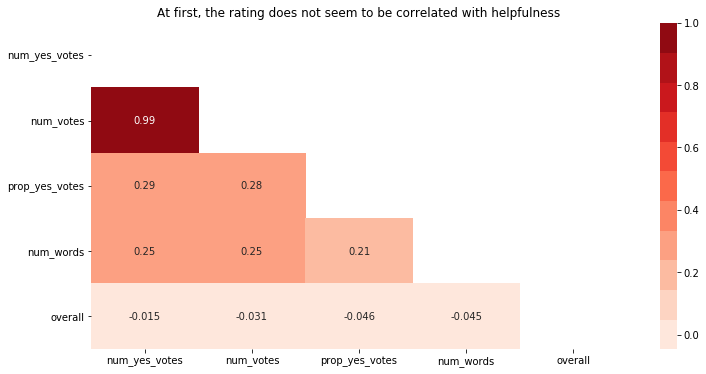

In [6]:
def plot_correlation_matrix(corr_matrix, plot_title=""):
    """
        Plot the lower triangle of the correlation matrix as a heatmap projection
        Arguments:
            corr_matrix: The correlation matrix to be plotted
            plot_title: The title of the plot
    """
    
    # Generate a mask to hide the upper triangle of the matrix
    mask = np.zeros_like(corr_matrix, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(12,6))
    sns.heatmap(corr_matrix, annot = True, cmap = sns.color_palette("Reds", 11), mask=mask)
    plt.title(plot_title)
    plt.show()
    
correlation = df[["num_yes_votes", "num_votes", "prop_yes_votes", "num_words", "overall"]].corr()
plot_correlation_matrix(correlation, 
                        plot_title="At first, the rating does not seem to be correlated with helpfulness")

In [7]:
(df["num_votes"] == 0).value_counts()

True     191656
False     87021
Name: num_votes, dtype: int64

At first it does seem that the `overall` column is not really correlated in any way in the helpfulness of the review (ether it be the number of "yes" votes, the number of votes or the proportion of "yes" votes). However, 191656 reviews (68.77%) don't have a single vote, when we discard these reviews the correlation is different

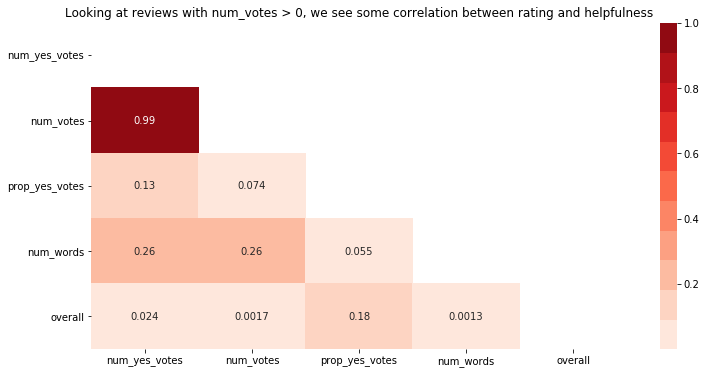

In [8]:
correlation_wout_zero_reviews = df.loc[df["num_votes"] != 0, ["num_yes_votes", "num_votes", "prop_yes_votes", "num_words", "overall"]].corr()
plot_correlation_matrix(correlation_wout_zero_reviews, 
                        plot_title="Looking at reviews with num_votes > 0, we see some correlation between rating and helpfulness")

When discarding reviews with no votes we see that there is a somewhat week correlation between `overall` and `prop_yes_votes`. This shows that the overall score is not really influenced by the number of "yes" votes, nor the total number of votes nor the number of words in the review. The overall score is, however, influenced by the proportion of "yes" votes the review have.

An interesting point is in the correlation between `num_yes_votes` and `num_votes`. It is obivous that this correlation should be positive (since `num_yes_votes` is a subset of `num_votes`) however it is interesting that it has such a high correlation. This indicates that an user only votes in a review if it was actually helpful to them, and if it was not then he/she probably just ignores it.

It is also interesting to see that `num_words` is correlated with `num_votes` (and with `num_yes_votes`) which inidicates that longer reviews tend to have more votes

## What is the median number of votes a review gets?

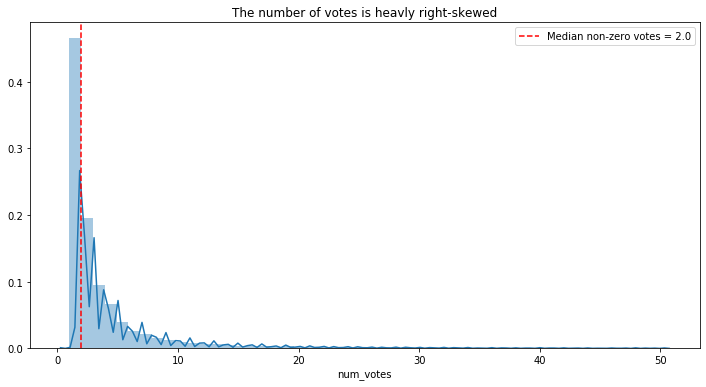

In [9]:
# Number of non-zero votes reviews = 87021

nonzero_votes_filtered = df.loc[(df["num_votes"] > 0) & (df["num_votes"] <= 50),  "num_votes"]
# nonzero_votes_filtered.shape[0] -> 86379

# 86379/87021 = 0.992 -> 99% of non-zeros reviews have between 1 and 50 votes,
# so we can safely discard the rest for this analysis

plt.figure(figsize=(12,6))
sns.distplot(nonzero_votes_filtered)
plt.axvline(x=nonzero_votes_filtered.median(), color="red", ls="--", label=f"Median non-zero votes = {nonzero_votes_filtered.median()}")
plt.title("The number of votes is heavly right-skewed")
plt.legend()
plt.show()

Using the median is favoured over the average for skewed distributions such as this one because it is not as heavly influenced by outliers (extreme values)
So the median number of votes a review genereally gets is 2. Given this we can consider a helpfull review to have a high proportion of "yes" votes (let's say above 0.5) and also have at least, for example, two times the number of median votes.

Another possible way to find helpful reviews would be to for example weight the proportion of "yes" votes with the number of votes it has (`prop_yes_votes * num_votes`). All this approaches have some assumptions about them, picking one should be validated with stakeholders.

For the binary target variable indicating if a reviewing is helpful or not we'll define it as having more than 4 votes and having more "yes" votes than "not yes" votes. (`prop_yes_votes` >= 0.5)

In [10]:
# Creating the binary target label indicating if a review was helpful or not
df["helpful_review"] = ((df["num_votes"] >= 4) & (df["prop_yes_votes"] >= 0.5)).astype(int)
df["helpful_review"].value_counts()

0    256782
1     21895
Name: helpful_review, dtype: int64

Only 7.857% are considered helpful according to our definition of helpful reviews. Alhtough there is still a large number of positive class observations there is some class imbalance and so accuracy should be discouraged as a model evaluation metric

## Who are the most helpful reviewers?

Here we're defining the helpfulness score of a reviewer as the product of the average proportion of "yes" votes their review gets, times the average number of "yes" votes they get times the number of reviews they made

What we're aiming with this is to find an user that has given many reviews and that have all been generally well received, or an user who has made few reviews but have many "yes" votes

In [11]:
top_reviwers = df.groupby("reviewerID").agg({
    "prop_yes_votes": "mean", 
    "num_yes_votes": "mean",
    "num_votes": "mean",
    "asin": "count" # this is just here to get the number of reviews the user has given 
})

top_reviwers["helpfulness_score"] = top_reviwers["prop_yes_votes"] * top_reviwers["num_yes_votes"] * top_reviwers["asin"] 

# sorting reviewers descendingly and taking the first 10
top_reviwers = top_reviwers.sort_values(by="helpfulness_score", ascending=False).head(10)

most_helpful_reviwer = df.loc[df['reviewerID'] == top_reviwers.index[0], 'reviewerName'].to_numpy()[0]
print(f"Most helpful reviewer: {most_helpful_reviwer}")
top_reviwers

Most helpful reviewer: Matthew G. Sherwin


,prop_yes_votes,num_yes_votes,num_votes,asin,helpfulness_score
reviewerID,,,,,
A2R6RA8FRBS608,0.821805,20.840000,23.460000,50,856.321185
A2REQUI85URT87,0.892409,113.428571,121.428571,7,708.572889
A2PQ3WXMKCT4NX,0.933694,79.111111,81.444444,9,664.789793
A2GGKJ318HO2GE,0.686537,87.181818,92.454545,11,658.389332
A30NHVVC62LJMK,0.853222,98.714286,99.000000,7,589.576170
AWBGHDHH7E51F,0.767272,16.422222,17.022222,45,567.013948
A38DSYHNBYZNUG,0.840817,77.625000,81.625000,8,522.147166
A1IU7S4HCK1XK0,0.985877,31.285714,33.642857,14,431.813961
A1F7YU6O5RU432,0.604314,16.095238,17.095238,42,408.516103


## And what are the most helpful reviews?

Here let's consider helpful reviewers those that have the highest proportion of "yes" votes and that have at least 4 votes.

In [12]:
# Find the most helpful reviews defined by having at least 4 votes
helpful_reviews = df.loc[df["num_votes"] >= 4, ["reviewText", "summary", "prop_yes_votes", "num_yes_votes", "num_votes"]]\
.sort_values(by=["prop_yes_votes", "num_yes_votes"], ascending=False)\
.head(10)

helpful_reviews

,reviewText,summary,prop_yes_votes,num_yes_votes,num_votes
28156,compartments designed read detailsthis thought...,best feature unique way,1.0,239,239
104230,us know pant size better hip circumference han...,sizing,1.0,227,227
81648,trying decide doctors kit buy torn one fisher ...,pretty good,1.0,154,154
111598,comfort king everything comes shoes beauty que...,comfort king,1.0,117,117
79505,update 51214 new purse arrived almost concerns...,updated version pretty much perfect,1.0,109,109
115764,product info mention umbrella diameter 38 one ...,far good,1.0,108,108
130772,ordered four different moving comfort bras im ...,comfortable job looks good easy get,1.0,107,107
65016,unlike reviewers walk paved road treadmill spe...,fits needs perfectly look nice boot,1.0,105,105
37103,wrote positive review earlier im retracting co...,save money,1.0,102,102
30345,hanes cotton briefs always favorite undies wea...,huge disappointment,1.0,98,98


## Are reviews getting more or less helpful over time?

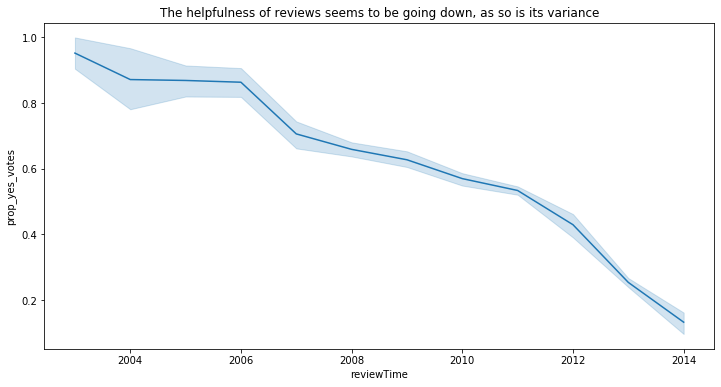

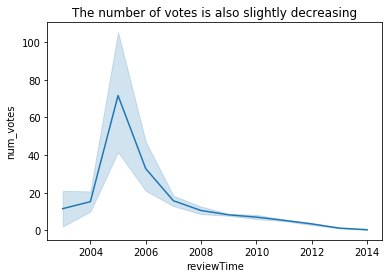

In [13]:
# Specify that we want a monthly period
period = df["reviewTime"].dt.to_period(freq="M")

# Group by every year/month and get the mean of the specified variables
grouped_data = df.groupby(period)[["prop_yes_votes", "num_votes", "overall"]].mean()

# Sort the index (which is the year/month)
grouped_data = grouped_data.sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped_data.index.year, y=grouped_data.prop_yes_votes)
plt.title("The helpfulness of reviews seems to be going down, as so is its variance")
plt.show()

sns.lineplot(x=grouped_data.index.year, y=grouped_data.num_votes)
plt.title("The number of votes is also slightly decreasing")
plt.show()

It does seem that the helpfulness of reviews is going down with time, along with its variance. This could be explained by the fact that older reviews have had more time to accumulate more votes (which explains why `num_votes` is also going down)

## And have users been giving higher or lower ratings to products?

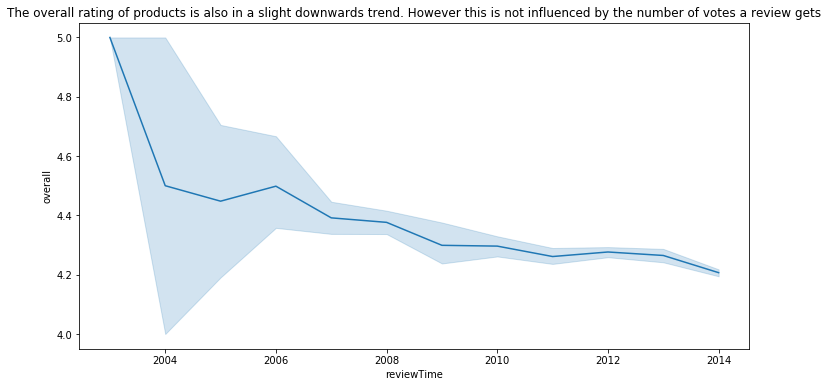

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped_data.index.year, y=grouped_data.overall)
plt.title("The overall rating of products is also in a slight downwards trend. However this is not influenced by the number of votes a review gets")
plt.show()

## Are helpful reviews longer?

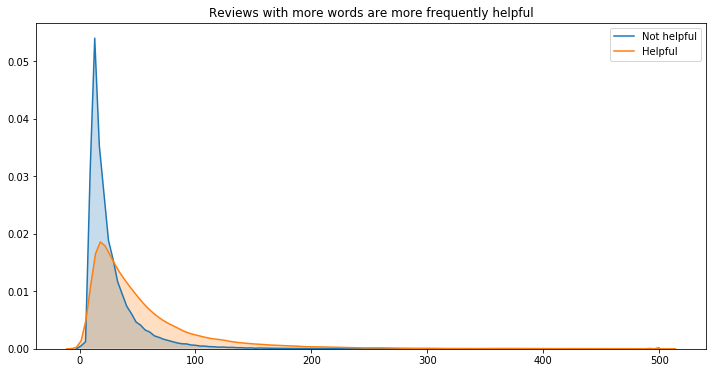

In [15]:
# Only considering sentences with num words between ]0, 500[
sentence_len_condition = (df["num_words"] > 0) & (df["num_words"] < 500)

plt.figure(figsize=(12, 6)) 
sns.kdeplot(df.loc[sentence_len_condition & (df["helpful_review"] == 0), "num_words"], shade=True, label="Not helpful")
sns.kdeplot(df.loc[sentence_len_condition & (df["helpful_review"] == 1), "num_words"], shade=True, label="Helpful")
plt.title("Reviews with more words are more frequently helpful")
plt.show()

This shows us that all reviews are generally short (they have a median of 20 meaningful words), but it is a little bit more frequent to find longer reviews being helpful than otherwise

## What are the most frequent words in helpful messages?

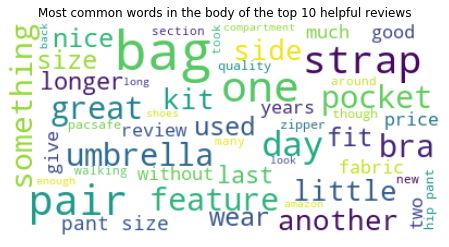

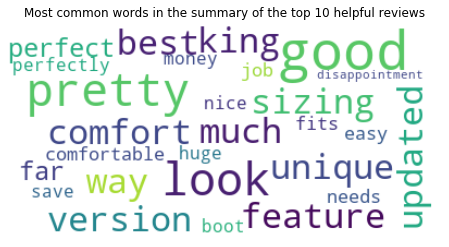

In [16]:
def plot_wordcloud(column, plot_title=""):
    """
        Plot the wordcloud of the concatenated string from the provided column
        Arguments:
            column: The column of interest to be concatenated
            plot_title: the title of the plot
    """
    
    try:
        # Concatenate the string column 
        concatenated_str = " ".join(helpful_reviews[column].to_numpy())
    except:
        print("Please pass a valid string column name")
        concatenated_str = ""
    
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", random_state=42)\
        .generate(concatenated_str)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(plot_title)
    plt.axis("off")
    plt.show()
    
    
plot_wordcloud("reviewText", plot_title="Most common words in the body of the top 10 helpful reviews")
plot_wordcloud("summary", plot_title="Most common words in the summary of the top 10 helpful reviews")

## Is there any kind of seasonal pattern in a year?

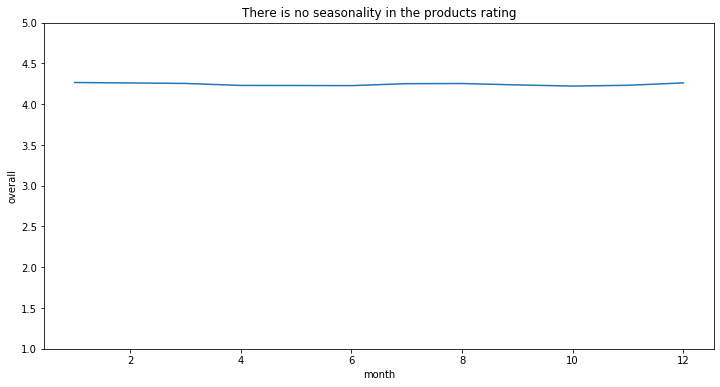

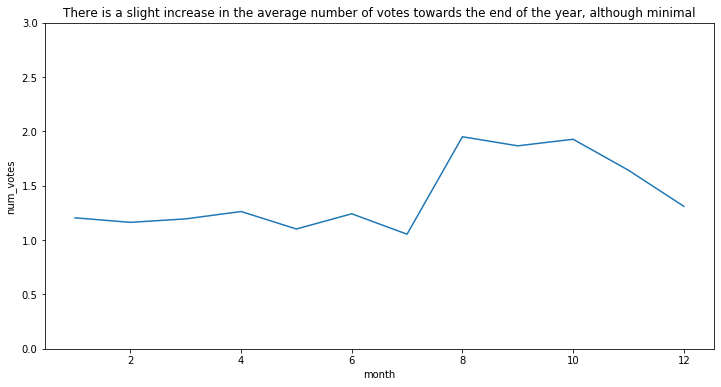

In [39]:
df["month"] = df["reviewTime"].apply(lambda dt: dt.month)

monthly_overall = df.groupby("month")[["overall", "num_votes", "num_words", "helpful_review"]].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_overall.index ,y=monthly_overall["overall"])
plt.ylim([1,5])
plt.title("There is no seasonality in the products rating")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_overall.index ,y=monthly_overall["num_votes"])
plt.ylim([0,3])
plt.title("There is a slight increase in the average number of votes towards the end of the year, although minimal")
plt.show()

What this tells us that the the top 10 reviews are generally positive reviews (which goes along with what is concluded in the correlation matrix analysis) but interestingly enough in the body of the review people tend to describe the product and dont use so many words as "great", "good", etc. It seems that it might be the fact that people (at least in these 10 reviews) use the summary to express their sentiment towards the item, and in the body of the review they describe why.

## Conclusion of these analysis:

With these preliminary analysis we conclude that:
- There exists some correlation between the overall score of a product and the helpfulness of a review, at least for reviews that have votes in them
- When a review gets a vote, it is often time a "yes" vote
- Reviews that have votes generally have a median of 2 votes
- Reviews tend to be getting less helpful over time, however this migh be due to older reviews having more time to accumulate more votes
- Helpful reviews are slightly longer than non-helpful reviews
- It appears people tend to use the summary to express their feelings towards the item and the body of the review to describe it
- There is no strong seasonality in the reviews

# Task 2. Modeling

## Research question: Is looking at the summary enough to find a review useful?

In this section we aim to understand if we can predict the usefulness of a review based on other reviews. Furthermore, it's interesting to understand if just by looking at the summary of a review is enough to identify its usefulness or is it required to read the entire review to extract useful information from it.

A new column containig the original text plust bi-grams is added. Bi-grams may be useful o pick up some common expressions in language suchs as "cardiovascular disease" instead of "cardiovascular" and "disease"

**NOTE**: Bi-grams were only added to the `summary` since adding bi-grams to the `reviewText` made the program crash during classification due to a high dimensionality

### Bi-grams

In [17]:
def add_bigrams(sentence):
    """
        Appends bi-grams of the sentence to the end
        Arguments:
            sentence: The input sentence in which to extract and append the bigrams
        Returns:
            The same sentence but with extract bigram tokens in the end
    """
    # Example use case: this is a sentence -> this is a sentence this_is is_a a_sentence
    
    tokens = nltk.word_tokenize(sentence)
    bigrams = nltk.bigrams(tokens)
    return sentence + " "+ " ".join(map('_'.join, bigrams))


df["summary_w_bigrams"] = df["summary"].apply(add_bigrams)
df["summary_w_bigrams"].iloc[0] # showing an example

'great tutu cheaply made great_tutu tutu_cheaply cheaply_made'

### TF-IDF

We can now create the TF-IDF representation of these words.

A common approach to extract features from text is to create a Bag of Words representation. In this representation a matrix is created where rows are formed by the different documents and columns are all existing terms in the corpus. This representation counts the occurence of terms in a document. However a problem arises where longer documents naturally have higher average count values than short documents. So a common solution is to apply Term frequency - Inverse document frequency normalization.

In this approach terms are normalized by their frequency in the document (TF) and by how rare they are, i.e. in how many documents they appear in (IDF)

In [18]:
def add_pandas_columns(df, columns, scale_new_columns=True):
    """
        Adds pandas columns to a sparse matrix. 
        Arguments:
            df: The sparse matrix in which to add the columns
            columns: The pandas columns to add to the sparse matrix
            scale_new_columns: Flag specifying if new columns should be scaled
        Returns:
            A sparse matrix with the extra columns added to it
    """
    
    scaler = StandardScaler()
    
    for _, col in columns.iteritems():    
        if scale_new_columns:    
            col_values = scaler.fit_transform(col.values.reshape(-1, 1))
            col_values = col_values.reshape(1, -1)
        else:
            col_values = col.values
            
        df = sparse.hstack((df, col.values[:,None])) # append column to sparse matrix
    
    return df

tf_idf = TfidfVectorizer(dtype=np.float32) # default is dtype=np.float64, we can same some memory this way

# TF-IDF vectorize the body of the review
X = tf_idf.fit_transform(df['reviewText'])

# TF-IDF vectorize the summary of the review
X_summary = tf_idf.fit_transform(df['summary'])
X_summary_bigrams = tf_idf.fit_transform(df['summary_w_bigrams'])

# Re-add columns to sparse matrix
X = add_pandas_columns(X, df[["num_words", "overall", "overall_deviation"]])

X_summary = add_pandas_columns(X_summary, df[["num_words", "overall", "overall_deviation"]])
X_summary_bigrams = add_pandas_columns(X_summary_bigrams, df[["num_words", "overall", "overall_deviation"]])

# Train-Test split

In order to perform a correct evaluation of our model we'll split our data intro train and test. The training set will be furthered splitted in to K-folds as to get a more robust validation of our model

Since we are dealing with a large dataset and we have a mild class imbalance, we can also undersample the negative class. This will lead to a greater balance between classes and most importantly will make the data more manageable, although we should be carefull as to not have much more columns than rows

In [19]:
def split_data(X, y, undersample=False):
    """
        Splits the dataset into train and test set
        Arguments:
            X - The input feature matrix
            y - The label column
            undersample - Flag indicating if undersampling should be performed
        Returns
            The input features and labels splitted into train and test
    """
    
    # Split the data into 70% train and 30% test (given we have a large amount of data) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.30)
    
    if undersample:
        ru = RandomUnderSampler()
        X_train, y_train = ru.fit_resample(X_train, y_train) # Undersampling just the training set
        
    return X_train, X_test, y_train, y_test


# Perform the splits for all feature matrix
X_train, X_test, y_train, y_test = split_data(X, df["helpful_review"])

X_sum_train, X_sum_test, y_sum_train, y_sum_test = split_data(X_summary, df["helpful_review"])
X_sum_bi_train, X_sum_bi_test, y_sum_bi_train, y_sum_bi_test = split_data(X_summary_bigrams, df["helpful_review"])

## Scaling features

Since our features are in very different scales (TF-IDF ranges from [0, 1] while num_words can be much larger) it is important to scale the dataset so that every feature is in the same scale. Some algorithms do not require scaling (e.g. Random Forests). This should be done after splitting into train and test in order to don't add any biases

In [20]:
def scale_df(df, scaler=None, fit_scaler=True):
    """
        Scales a dataframe with the given scaler
        Arguments:
            df: The dataframe to be scaled
            scaler: The scaler to scale the dataframe
            fit_scaler: Whether or not to fit the scaler
        Returns:
            The scaled dataframe and the scaler user (so it can be reused)
    """
    
    if scaler is None:
        scaler = StandardScaler(with_mean=False) # sparse matrices shouldn't be centered to preserve sparcity
        
    if fit_scaler:
        scaler.fit(df)
        
    return scaler.transform(df), scaler
    
X_train, scaler = scale_df(X_train)
X_test, _ = scale_df(X_test, scaler, fit_scaler=False)

X_sum_train, scaler = scale_df(X_sum_train)
X_sum_test, _ = scale_df(X_sum_test, scaler, fit_scaler=False)
    
X_sum_bi_train, scaler = scale_df(X_sum_bi_train)
X_sum_bi_test, _ = scale_df(X_sum_bi_test, scaler, fit_scaler=False)

## Modeling

To evaluate our model we'll use ROC-AUC. Since we are in a case of class imbalance it is good to consider a metric that is more robust in these situations (unlike accuracy). ROC-AUC also has the advantage of considering all possible decision thresholds (unlike F metric). Althoug some studies ([here](https://dl.acm.org/doi/proceedings/10.1145/1143844) and  [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)) suggest that ROC-AUC might not be the best suited for skewed datasets and that PR-AUC can be more indicative of model performance for this types of datasets, ROC-AUC is still used due to it being a more common metric and thus more comparable with other studies

In [21]:
train_set = lgb.Dataset(X_train, label=y_train)

In [22]:
%%time

def perform_cv(params, n_folds=5):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round=10, nfold=n_folds, 
                        early_stopping_rounds=100, metrics='auc', seed=42)
    
    # Return list of results
    return np.mean(cv_results['auc-mean'])

lgbm_params ={"num_leaves": [25, 50],
              "subsample": [0.8, 1.0],
              "colsample_bytree": [0.8, 1.0],
              "is_unbalance": [True],
              "objective": ["binary"]
            }


param_list = list(ParameterGrid(lgbm_params))
cv_scores = []
for params in param_list:
    cv_scores.append(perform_cv(params))

CPU times: user 6min 44s, sys: 24.5 s, total: 7min 9s
Wall time: 1min 48s


In [23]:
param_list[np.argmax(cv_scores)]

{'colsample_bytree': 0.8,
 'is_unbalance': True,
 'num_leaves': 25,
 'objective': 'binary',
 'subsample': 0.8}

In [24]:
%%time
num_round = 10
bst = lgb.train(param_list[np.argmax(cv_scores)], train_set, num_round)

CPU times: user 7.27 s, sys: 459 ms, total: 7.73 s
Wall time: 1.95 s


In [26]:
ypred = bst.predict(X_test)

In [27]:
ypred = (ypred > 0.5).astype(int)
print(roc_auc_score(y_test, ypred))
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

0.6180684606561482
[[70599  6436]
 [ 4469  2100]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     77035
           1       0.25      0.32      0.28      6569

    accuracy                           0.87     83604
   macro avg       0.59      0.62      0.60     83604
weighted avg       0.89      0.87      0.88     83604



# BERT usage

In [6]:
df_bert = pkl.load(open("../data/bert_encoded_summary.pkl", "rb"))

# Scale non-bert features

In [8]:
bert_scaler = StandardScaler()

feats_to_scale = df_bert[["num_words", "overall", "overall_deviation"]]

scaled_df = pd.DataFrame(bert_scaler.fit_transform(feats_to_scale), columns=feats_to_scale.columns)

# Re-adding features
df_bert["num_words"] = scaled_df["num_words"]
df_bert["overall"] = scaled_df["overall"]
df_bert["overall_deviation"] = scaled_df["overall_deviation"]

In [10]:
%%time
X_bert_embedded = PCA(n_components=2, random_state=42).fit_transform(df_bert.drop(["helpful_review", "original_summary"], axis=1)) 

CPU times: user 9.25 s, sys: 1.34 s, total: 10.6 s
Wall time: 3.03 s


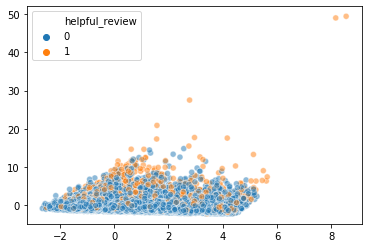

In [11]:
sns.scatterplot(x=X_bert_embedded[:, 0], y=X_bert_embedded[:, 1], hue=df_bert["helpful_review"], alpha=0.5)